<a href="https://colab.research.google.com/github/Manika7777/CSI_WEEK5_MS/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Loading the Dataset*

In [60]:
import zipfile
import os

# Set new path
zip_path = '/content/house-prices-advanced-regression-techniques.zip'
extract_path = '/content/house_data'

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)


['data_description.txt', 'train.csv', 'test.csv', 'sample_submission.csv']

# *Load the Data*

In [61]:
import pandas as pd

# Load training and testing data
train = pd.read_csv('/content/house_data/train.csv')
test = pd.read_csv('/content/house_data/test.csv')

# Check shape and preview
print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# *Combine Train and Test for Preprocessing*

In [62]:
# Save target variable and test IDs
y = train['SalePrice']
test_ID = test['Id']

# Drop SalePrice from train and combine with test
combined = pd.concat([train.drop(['SalePrice'], axis=1), test], axis=0)

print("Combined shape:", combined.shape)


Combined shape: (2919, 80)


# *Handle Missing Values*

In [63]:
# Fill categorical NaNs with 'None'
categorical_cols = combined.select_dtypes(include='object').columns
combined[categorical_cols] = combined[categorical_cols].fillna('None')

# Fill numerical NaNs with median
numerical_cols = combined.select_dtypes(exclude='object').columns
combined[numerical_cols] = combined[numerical_cols].fillna(combined[numerical_cols].median())


# *Feature Engineering*

In [64]:
# Total square footage
combined['TotalSF'] = combined['TotalBsmtSF'] + combined['1stFlrSF'] + combined['2ndFlrSF']

# Total bathrooms
combined['TotalBath'] = (combined['FullBath'] + combined['HalfBath'] * 0.5 +
                         combined['BsmtFullBath'] + combined['BsmtHalfBath'] * 0.5)

# Age of the house
combined['HouseAge'] = combined['YrSold'] - combined['YearBuilt']


# *Encoding Categorical Features*

In [65]:
combined = pd.get_dummies(combined)
print("Shape after encoding:", combined.shape)


Shape after encoding: (2919, 314)


# *Split Back into Train and Test*

In [66]:
X_train = combined[:len(train)]
X_test = combined[len(train):]


# *Training a Linear Regression Model*

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define X (processed features) from the combined DataFrame
X = combined[:len(train)]  # Use only training rows

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)


# *Calculate the mean squared error (MSE), root mean squared error (RMSE) and R-squared score*

In [79]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 🎯 Step 1: Log-transform the target variable
y_log = np.log1p(y)  # log(1 + SalePrice)

# 🧪 Step 2: Scale numerical features only
scaler = StandardScaler()
X_scaled = combined.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X_scaled[numerical_cols])

# 🔁 Step 3: Split scaled features back into train/test
X_train_full = X_scaled[:len(train)]
X_test = X_scaled[len(train):]

# ✂️ Step 4: Train-validation split
X_train, X_val, y_train_log, y_val_log = train_test_split(X_train_full, y_log, test_size=0.2, random_state=42)

# 🧠 Step 5: Ridge Regression Model
model = Ridge(alpha=10)
model.fit(X_train, y_train_log)

# 🔮 Step 6: Predict and invert log transformation
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val_log)

# 📊 Step 7: Evaluation
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("📊 Model Evaluation Summary")
print("-" * 35)
print(f"🧮 Mean Squared Error (MSE):        {mse:,.2f}")
print(f"📏 Root Mean Squared Error (RMSE):  {rmse:,.2f}")
print(f"📈 R² Score (Coefficient of Determination): {r2:.4f}")


📊 Model Evaluation Summary
-----------------------------------
🧮 Mean Squared Error (MSE):        631,201,196.72
📏 Root Mean Squared Error (RMSE):  25,123.72
📈 R² Score (Coefficient of Determination): 0.9177


# ***Visualization***

# *Distribution of Sale Prices*

In [69]:
import plotly.express as px

# Assuming 'train' DataFrame is loaded and contains 'SalePrice' and 'Neighborhood'
px.histogram(
    train,
    x='SalePrice',
    nbins=50,
    color='Neighborhood',
    title='Distribution of Sale Prices',
    width=1000,
    height=500
).show()


# *Plot: Actual vs Predicted House Prices*

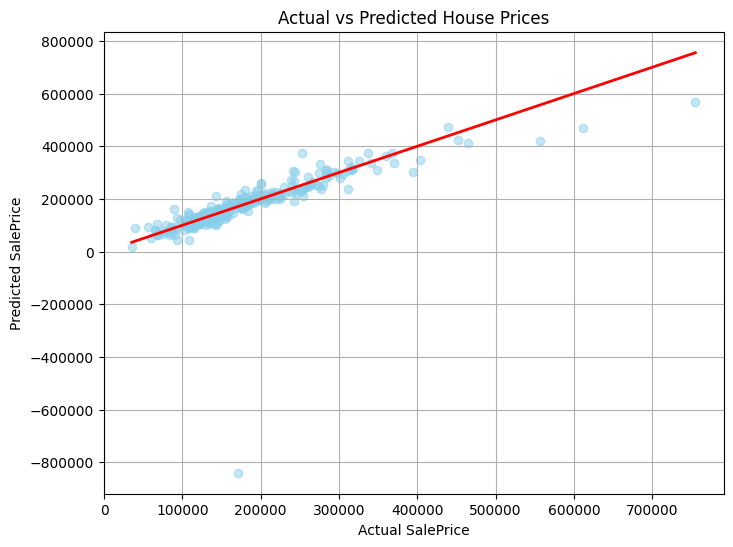

In [70]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.5, color='skyblue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()


# *Actual vs Predicted (R² = 0.9177)*

In [71]:
import plotly.express as px
import pandas as pd

# Create DataFrame of actual vs predicted values
df_plot = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred
})

# Plot: Actual vs Predicted with Trendline
fig = px.scatter(
    df_plot,
    x='Actual',
    y='Predicted',
    trendline='ols',
    title='Actual vs Predicted',
    color_discrete_sequence=['#636EFA']  # Optional: Customize color
)
fig.update_layout(
    title_font_size=20,
    xaxis_title='Actual',
    yaxis_title='Predicted',
    width=1000,
    height=500
)
fig.show()


# *Sorted Line Plot for Actual vs Predicted Sale Prices*

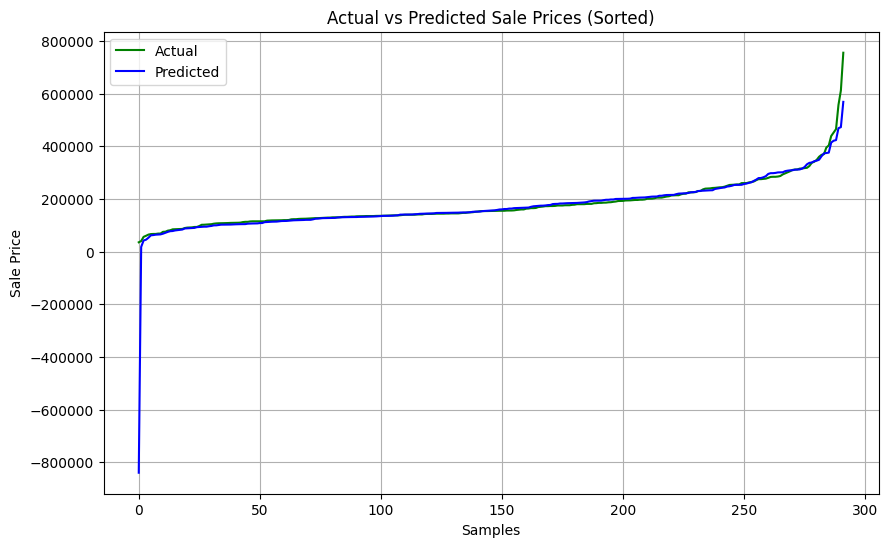

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_val)), y_val.sort_values().values, label='Actual', color='green')
plt.plot(range(len(val_preds)), np.sort(val_preds), label='Predicted', color='blue')
plt.title('Actual vs Predicted Sale Prices (Sorted)')
plt.xlabel('Samples')
plt.ylabel('Sale Price')
plt.legend()
plt.grid(True)
plt.show()


# *Sorted Line Plot: Actual vs Predicted Sale Prices*

In [72]:
import pandas as pd
import plotly.express as px

# Create a DataFrame of Actual vs Predicted values
df_line = pd.DataFrame({
    'Actual': y_val.values,
    'Predicted': y_pred
})

# Sort values by Actual to ensure smooth line
df_line_sorted = df_line.sort_values(by='Actual').reset_index(drop=True)

# Melt the dataframe for plotly line plotting
df_melted = df_line_sorted.reset_index().melt(id_vars='index', value_vars=['Actual', 'Predicted'])

# Line Plot
fig = px.line(
    df_melted,
    x='index',
    y='value',
    color='variable',
    title='Line Plot: Actual vs Predicted'
)
fig.update_layout(
    xaxis_title='_index',
    yaxis_title='Value',
    width=1000,
    height=500
)
fig.show()


# *Predicting on Test Set and Save Submission*

In [73]:
# Predict on test set
test_preds = model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': test_preds
})

# Save CSV
submission.to_csv('house_price_predictions.csv', index=False)
print("✅ Submission file saved as 'house_price_predictions.csv'")


✅ Submission file saved as 'house_price_predictions.csv'


# *Download the Submission File*

In [74]:
from google.colab import files
files.download('house_price_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# *Residual Plot*

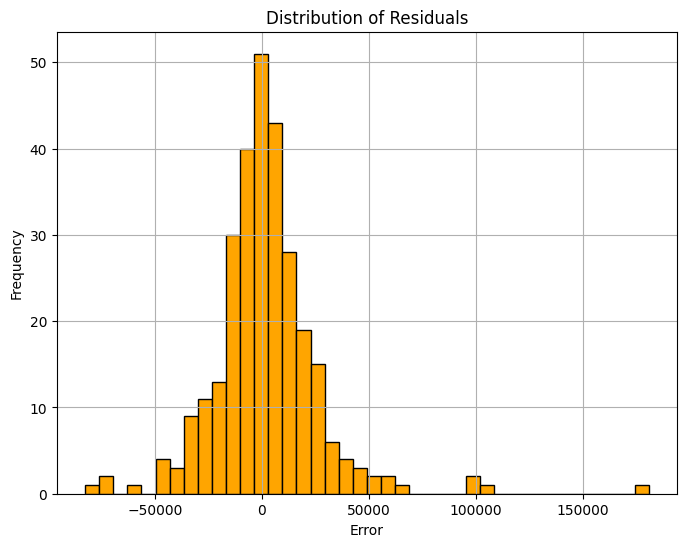

In [81]:
# 📉 Residuals
residuals = y_val - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=40, color='orange', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


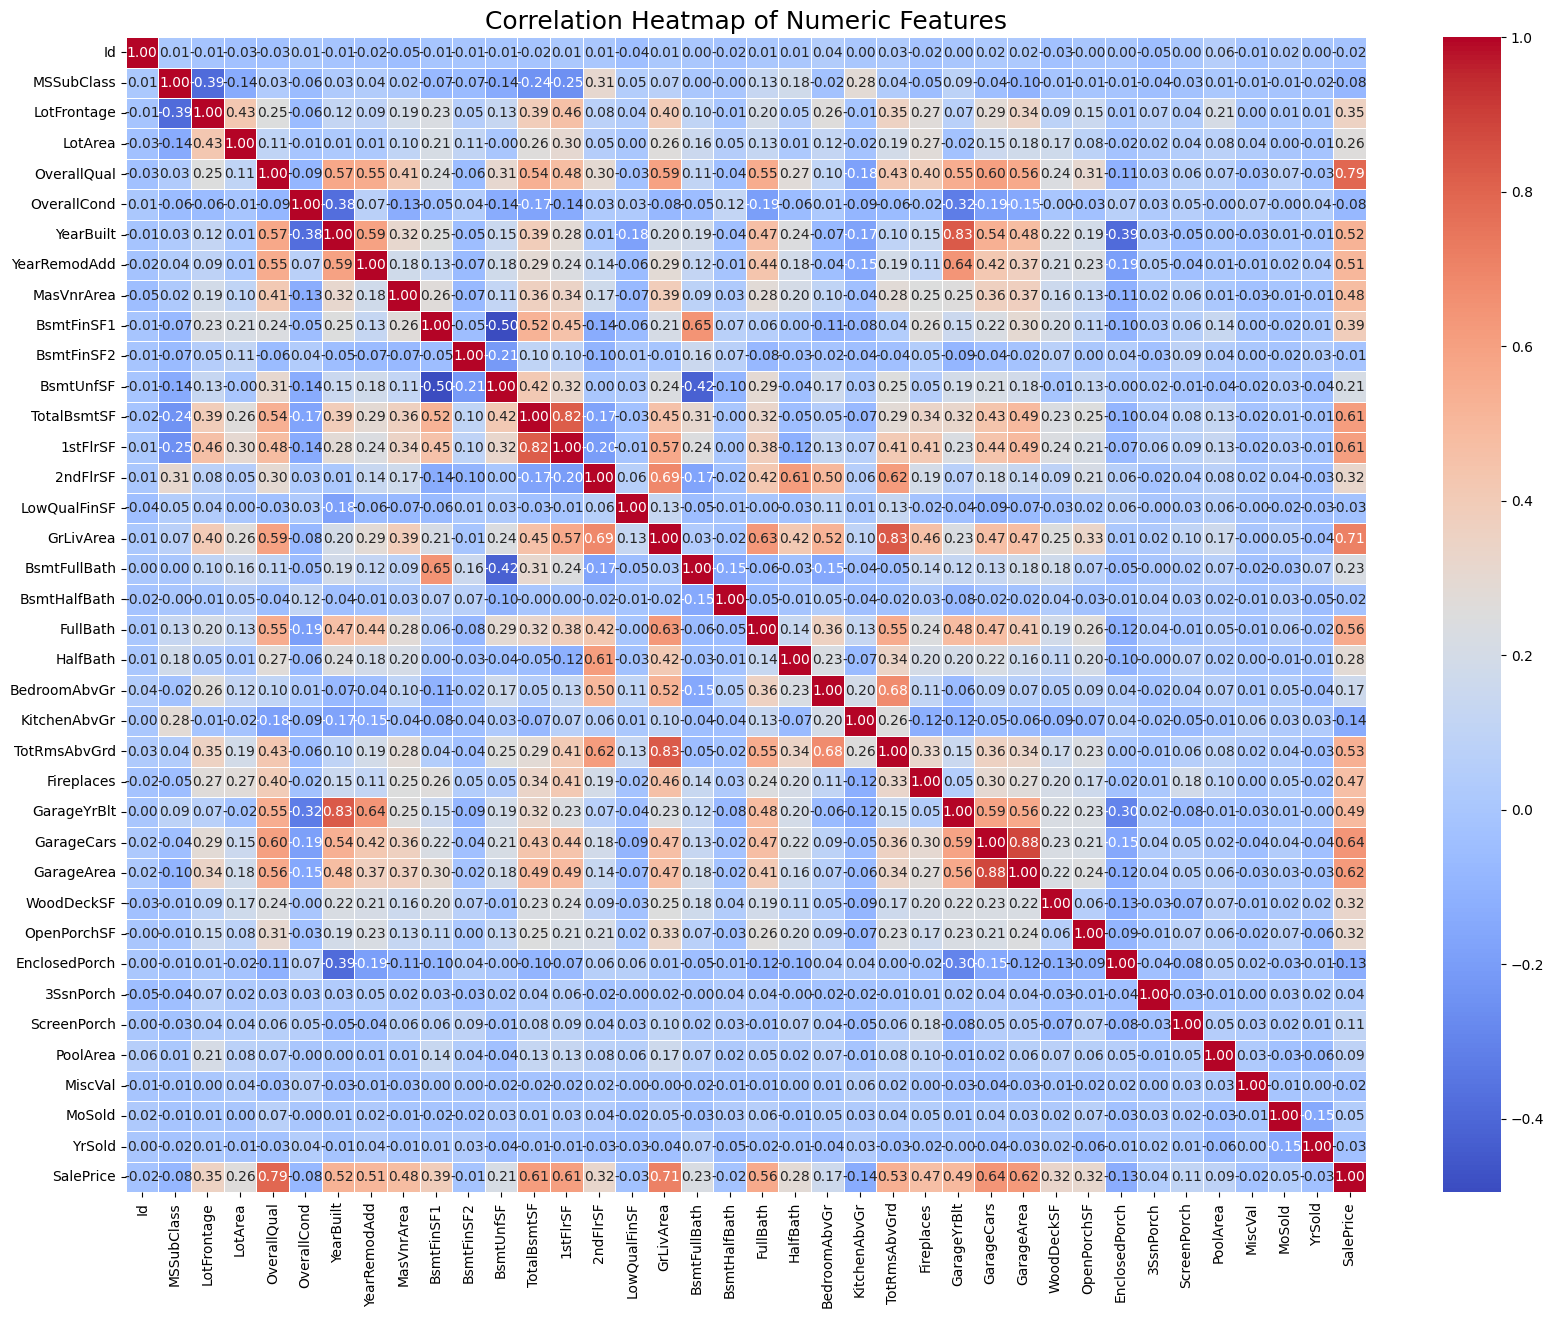

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric features
numeric_features = train.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_features.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))  # Bigger figure for clarity
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=18)
plt.show()
